# Article figures for Asilomar SSA wave transformation

In [175]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import statsmodels.api as sm
from datetime import datetime as DT
import cmocean
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import salem
import utm
from pyproj import Proj
# Interactive plots
%matplotlib widget 
from roxsi_pyfuns import stats as rps
from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import wave_spectra as rpws

# Paths, files
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray'
pc_root = '/home/mikapm/ROXSI/Asilomar2022/SmallScaleArray'
# Figure output
outdir = os.path.join(pc_root, 'Article_figures')
# Bathymetry
bathydir = os.path.join(rootdir, 'Bathy')
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy_updated_50cm.nc')
dsb = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))
# Signature 1000 ADCP data
sig_root = os.path.join(rootdir, 'Signatures', 'Level1')
# Vector ADCP data
vec_root = os.path.join(rootdir, 'Vectors', 'Level1')

Figure 1: Study site & bathymetry

In [159]:
# Plot w/ google satellite image following example from
# https://salem.readthedocs.io/en/stable/auto_examples/plot_googlestatic.html
fn_fig1 = os.path.join(outdir, 'fig1.png')
if not os.path.isfile(fn_fig1):
    utm_zone = 10 # Standard UTM zone number (northern hemisphere)
    FFX = 0 # Fudge Factor in x (East)
    FFY = -5 # Fudge Factor in y (North) -5 seems to work well

    # UTM coordinates of box corners and middle of rock from GPS 
    # measurements of safety sausage from boat. Errors in these are 
    # up to several meters due to GPS error and currents
    IN = [594490.19 + FFX, 4053805.82 + FFY] # Inshore North
    ON = [594478.45 + FFX, 4053815.67 + FFY] # Offshore North
    OS = [594470.48 + FFX, 4053808.93 + FFY] # Offshore South
    IS = [594477.74 + FFX, 4053799.02 + FFY] # Inshore South
    PEAK = [594475.87 + FFX, 4053806.77 + FFY] # Middle of rock

    # UTM coordinates of box corners and middle of rock, 
    # approximated by eye based on estimated positions relative 
    # to bathymetric features 
    IS_est = np.array([0.594476227663551, 4.053794712172897]) * 1e6
    OS_est = np.array([0.594470871355140, 4.053806078995327]) * 1e6
    IN_est = np.array([0.594488330467290, 4.053799782266355]) * 1e6
    ON_est = np.array([0.594479294252336, 4.053812580163552]) * 1e6

    # Calculate line segment lengths
    ON_IN = np.sqrt((ON[0]-IN[0])**2 + (ON[1]-IN[1])**2)
    IN_IS = np.sqrt((IN[0]-IS[0])**2 + (IN[1]-IS[1])**2)
    IS_OS = np.sqrt((IS[0]-OS[0])**2 + (IS[1]-OS[1])**2)
    OS_ON = np.sqrt((OS[0]-ON[0])**2 + (OS[1]-ON[1])**2)

    ON_IN_est = np.sqrt((ON_est[0]-IN_est[0])**2 + 
                        (ON_est[1]-IN_est[1])**2)
    IN_IS_est = np.sqrt((IN_est[0]-IS_est[0])**2 + 
                        (IN_est[1]-IS_est[1])**2)
    IS_OS_est = np.sqrt((IS_est[0]-OS_est[0])**2 + 
                        (IS_est[1]-OS_est[1])**2)
    OS_ON_est = np.sqrt((OS_est[0]-ON_est[0])**2 + 
                        (OS_est[1]-ON_est[1])**2)

    # Select subset of bathymetry data in region around small-scale 
    # array. Make a box that lines up with UTM of subsurface buoys 
    # with a buffer region around it. 
    BUFFERREGION = 10  # size of buffer region beyond coords of subsurface buys
    eastingMin = min(np.array([IN[0],ON[0],OS[0],IS[0]]) - BUFFERREGION)
    eastingMax = max(np.array([IN[0],ON[0],OS[0],IS[0]]) + BUFFERREGION)
    northingMin = min(np.array([IN[1],ON[1],OS[1],IS[1]]) - BUFFERREGION)
    northingMax = max(np.array([IN[1],ON[1],OS[1],IS[1]]) + BUFFERREGION)
    vmin = -8.0
    vmax = -3.5
    
    # Initialize figure
    # fig, ax = plt.subplots(figsize=(7,7), constrained_layout=True)

    fig, axes = plt.subplots(figsize=(15,7.5), ncols=2, nrows=2, height_ratios=[4,1])
    gs = axes[0, 0].get_gridspec()
    # remove the underlying axes
    for ax in axes[:, 0]:
        ax.remove()
    axbig = fig.add_subplot(gs[:, 0])

    # Define background boundaries for plot (P)
    buffer = 140 # Buffer distance (m)
    latMinP, lonMinP = utm.to_latlon(eastingMin-buffer+120, northingMin-buffer, 
                                     zone_number=utm_zone, northern=True)
    latMaxP, lonMaxP = utm.to_latlon(eastingMax+buffer+120, northingMax+buffer, 
                                     zone_number=utm_zone, northern=True)

    # If you need to do a lot of maps you might want
    # to use an API key and set it here with key='YOUR_API_KEY'
    g = salem.GoogleVisibleMap(x=[lonMinP, lonMaxP], y=[latMinP, latMaxP],
                               scale=2,  # scale is for more details
                               maptype='satellite',
                               )
    # The google static image is a standard rgb image
    ggl_img = g.get_vardata()

    # Make a map of the same size as the image (no country borders)
    sm = salem.Map(g.grid, factor=2, countries=False)
    sm.set_shapefile()  # add the glacier outlines
    sm.set_rgb(ggl_img)  # add the background rgb image
    sm.set_scale_bar(location=(0.13, 0.12), color='white')  # add scale
    sm.set_lonlat_contours(max_nticks=6)
    sm.visualize(ax=axes[0,1])  # plot it

    # Mark SSA location with star
    proj_utm = Proj(proj='utm', zone=utm_zone, ellps='WGS84', preserve_units=False)
    em = (eastingMax + eastingMin) / 2
    nm = (northingMax + northingMin) / 2
    latm, lonm = utm.to_latlon(em, nm, zone_number=utm_zone, northern=True)
    # Convert to UTM
    xpu, ypu = proj_utm(lonm, latm)
    # Convert UTM coordinates to google image projection
    xp, yp = sm.grid.transform(xpu, ypu, crs=proj_utm)
    axes[0,1].scatter(xp, yp, marker='*', c='salmon', edgecolors='k', s=350)

    # Annotate (b)
    axes[0,1].annotate('(b)', xy=(0.02, 0.93), xycoords='axes fraction', fontsize=18, 
                color='white')

#     # Show/save plot
#     plt.tight_layout()
#     # plt.show()
#     if not os.path.isfile(fn_fig1a):
#         plt.savefig(fn_fig1a, bbox_inches='tight', dpi=450)
#     plt.close()

# # Bathymetry plot with mean transect line
# fn_fig1b = os.path.join(outdir, 'bathymetry_zoom.png')
# if not os.path.isfile(fn_fig1b):
#     fig, axes = plt.subplots(figsize=(7,7), nrows=2, height_ratios=[4,1], sharex=True)
    vmin = -8 
    vmax = -4
    # Set zoom in region
    x0 = dsb.C3.attrs['x_loc'].round() # C3 mooring location in the middle
    y0 = dsb.C3.attrs['y_loc'].round()
    xmin = x0 - 15
    xmax = x0 + 15
    ymin = y0 - 15
    ymax = y0 + 15
    bathy_zoom = dsb.z_msl.sel(x=slice(xmin, xmax), y=slice(ymin, ymax)).copy()
    im = bathy_zoom.plot.pcolormesh(ax=axbig, add_colorbar=False, vmin=vmin, vmax=vmax,
                                    cmap=cmocean.cm.deep_r)
    # Colorbar on right
    cax = axbig.inset_axes([1.01, 0.00, 0.05, 1.0], transform=axbig.transAxes)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_title(r'  $z$ [m]')
    # Take 1D transect to plot on bottom row
    ymin_t = y0 - 3
    ymax_t = y0 + 3
    transect = dsb.z_msl.sel(x=slice(xmin, xmax), y=slice(ymin_t, ymax_t)).mean(dim='y')
    # Mark boundaries of transect
    axbig.axhline(ymin_t, ls='--', lw=2, color='white')
    axbig.axhline(ymax_t, ls='--', lw=2, color='white')
    # Mark and annotate moorings
    x_c1, y_c1 = (dsb.C1.attrs['x_loc'], dsb.C1.attrs['y_loc']) # C1 (Sig)
    x_c6, y_c6 = (dsb.C6.attrs['x_loc'], dsb.C6.attrs['y_loc']) # C6 (Sig)
    x_c2, y_c2 = (dsb.C2.attrs['x_loc'], dsb.C2.attrs['y_loc']) # C2 (Vec)
    x_c5, y_c5 = (dsb.C5.attrs['x_loc'], dsb.C5.attrs['y_loc']) # C5 (Vec)
    x_l1, y_l1 = (dsb.L1.attrs['x_loc'], dsb.L1.attrs['y_loc']) # L1 (Vec)
    x_l5, y_l5 = (dsb.L5.attrs['x_loc'], dsb.L5.attrs['y_loc']) # L1 (Vec)
    axbig.scatter(x0, y0, marker='s', color='darkviolet', s=250, edgecolors='k') # C3
    axbig.text(x0-2.5, y0+1.25, s='SM/VM', color='darkviolet', fontsize=18)
    axbig.scatter(x_c1, y_c1, marker='o', color='tomato', s=250, edgecolors='k') 
    axbig.text(x_c1-1.25, y_c1+1, s='SO', color='tomato', fontsize=18)
    axbig.scatter(x_c6, y_c6, marker='o', color='tomato', s=250, edgecolors='k') 
    axbig.text(x_c6-0.75, y_c6+1, s='SI', color='tomato', fontsize=18)
    axbig.scatter(x_c2, y_c2, marker='^', color='royalblue', s=250, edgecolors='k') 
    axbig.text(x_c2-1, y_c2+1, s='VO', color='blue', fontsize=18)
    axbig.scatter(x_c5, y_c5, marker='^', color='royalblue', s=250, edgecolors='k') 
    axbig.text(x_c5-0.5, y_c5-2.25, s='VI', color='blue', fontsize=18)
    axbig.scatter(x_l1, y_l1, marker='^', color='royalblue', s=250, edgecolors='k') 
    axbig.text(x_l1-0.7, y_l1-2.25, s='VS', color='royalblue', fontsize=18)
    axbig.scatter(x_l5, y_l5, marker='^', color='royalblue', s=250, edgecolors='k') 
    axbig.text(x_l5-1, y_l5+1, s='VN', color='royalblue', fontsize=18)
    # No xlabel for top axis
    axbig.set_xlabel(r'Local $x$ coordinates [m]', fontsize=12)
    axbig.set_ylabel(r'Local $y$ coordinates [m]', fontsize=12)
    # Make x axis for transect
    xt = transect.x.values - xmin
    # ax=axes[1].plot(xt, transect.values, color='k')
    transect.plot(ax=axes[1,1], color='k')
    axes[1,1].fill_between(transect.x.values, -9, transect.values, color='lightgray')
    # Mark C1, C3, C6 mooring locations with vertical lines
    axes[1,1].axvline(x_c1, color='k', ls='--')
    axes[1,1].axvline(x0, color='k', ls='--')
    axes[1,1].axvline(x_c6, color='k', ls='--')
    # Remove empty space from x axis
    axes[1,1].margins(x=0)
    # Limits, labels
    axes[1,1].set_ylim([-9,-4])
    axes[1,1].set_ylabel(r'$z_\mathrm{\, t}$ [m]', fontsize=12)
    axes[1,1].set_xlabel(r'Local $x$ coordinates [m]', fontsize=12)
    # Tick label font sizes
    for ax in [axbig, axes[1,1]]:
        ax.tick_params(axis='both', which='major', labelsize=12)
    # Annotate (b), (c)
    axbig.annotate('(a)', xy=(0.02, 0.95), xycoords='axes fraction', fontsize=18, 
                   color='white')
    axes[1,1].annotate('(c)', xy=(0.02, 0.75), xycoords='axes fraction', fontsize=18, 
                     color='k')

    plt.tight_layout()
    if not os.path.isfile(fn_fig1):
        plt.savefig(fn_fig1, bbox_inches='tight', dpi=600)
    plt.close()


print('Done.')

Done.


Figure 2: Time series of wave parameters

Reading 103088-C1 netcdf files ...
Reading 103094-C3 netcdf files ...
Reading 103110-C6 netcdf files ...


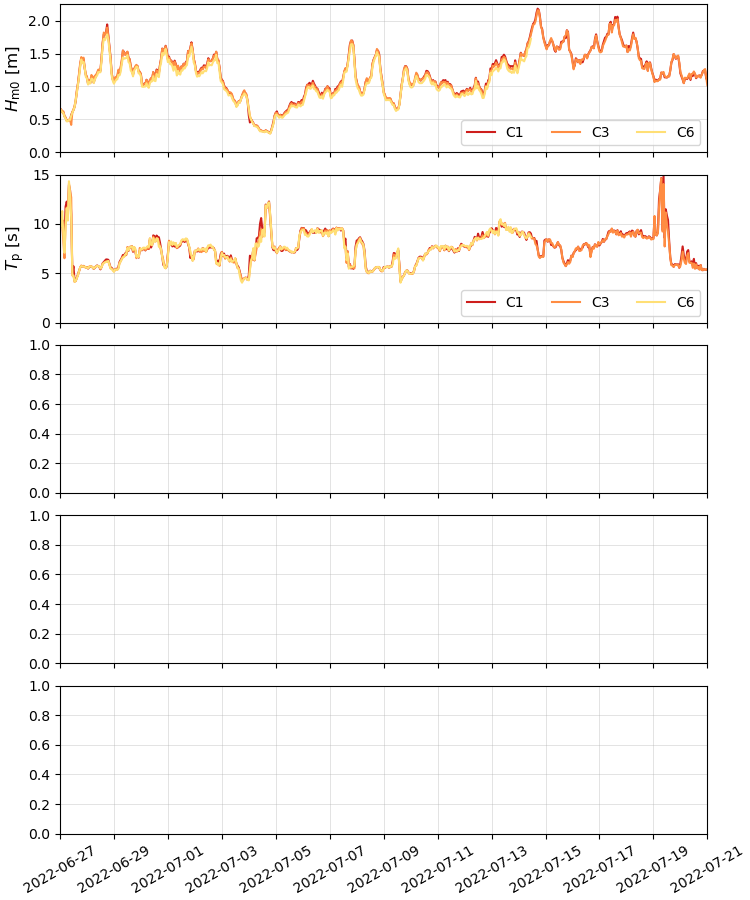

In [203]:
# Sig100 serial number to visualize
sers = ['103088', '103094', '103110',]# '103063', '103206']
mids = ['C1', 'C3', 'C6',]# 'L1', 'L5'] # Mooring IDs
sig_mids = ['SO', 'SM', 'SI'] # Signature mooring IDs to use in paper
# Use all available serial numbers
spec_key = 'ASTd' # Spectrum heave product
# Save mean datasets in dict
dsds = {} # Spectrum datasets
for ser, mid in zip(sers, mids):
    print('Reading {}-{} netcdf files ...'.format(ser, mid))
    # Get current serial number's spectrum directories
    specdir = os.path.join(sig_root, '{}'.format(ser), 'Spectra') 
    # Get spectrum netcdf file
    fn_nc_spec = os.path.join(specdir, 
                              'Asilomar_2022_SSA_Signature_{}_spec_AST.nc'.format(
                                  ser))
    dss = xr.decode_cf(xr.open_dataset(fn_nc_spec, decode_coords='all'))
    dsds[mid] = dss # Save in dict

# Get Vector Urms and mean w
# Iterate over requested moorings, figure out which bursts to skip
print('Finding bursts to skip ...')
for mid, ser in zip(mids, sers):
    print('{} - {}'.format(mid, ser))
    # Read netcdf file, check if need to concatenate multiple days
    if ((t1.date() - t0.date()).total_seconds() / spd) > 0:
        # More than one day -> concatenate daily datasets
        drc = pd.date_range(t0.date(), t1.date(), freq='1D') # Range of dates
        dlc = [] # List for concatenating
        for d in drc:
            ncdir = os.path.join(vec_root, mid)
            fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(
                ser, str(d.strftime('%Y%m%d'))))
            dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
            # Append to list
            dlc.append(dsv)
        # Concatenate daily datasets
        dsv = xr.concat(dlc, dim='time')
    else:
        # Only one day
        ncdir = os.path.join(vec_root, mid)
        fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(ser, 
            str(t0.strftime('%Y%m%d'))))
        dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))

    # Iterate over bursts
    for t0b in time_range:
        t1b = t0b + pd.Timedelta(hours=1)
        if t1b > t1:
            continue
        # Select sample period
        seg = dsv.sel(time=slice(t0b, t1b))
        # Check if too many spikes
        spikes_frac = np.sum(~np.isclose(seg.uz, seg.uzd)) / len(seg.uz)
        if spikes_frac > max_spikes_frac:
            # Too many spikes - skip burst
            print(f'Spike fraction {spikes_frac:.2f} > {max_spikes_frac} -> skipping')
            skip_list.append(t0b) # Append burst start time to skip list


# Main loop to iterate over desired moorings
print('Main loop ...')
for mid, ser in zip(mids, sers):
    print('{} - {}'.format(mid, ser))
    # Read Vector netcdf file
    ncdir = os.path.join(vec_root, mid)
    fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(ser, 
        str(t0.strftime('%Y%m%d'))))
    dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))

    # Filename of burst diss. rate csv file
    csvdir = os.path.join(ncdir, 'dissipation_rate')
    if not os.path.isdir(csvdir):
        os.mkdir(csvdir)
    fn_csv_diss = os.path.join(csvdir, 'burst_diss_{}_{}_nhours_{}.csv'.format(
        mid, t0.strftime('%Y%m%d_%H%M'), nhours))
    if not os.path.isfile(fn_csv_diss):
        # Wave counter
        wcnt = 0
        # Iterate over bursts
        for t0b in time_range:
            t1b = t0b + pd.Timedelta(hours=1)
            if t1b > t1:
                continue
            # Check bursts to skip based on non-stationary tilt angles or spikes
            if mstr == 'C2C3C4' and t0b in dfsk.values:
                # Bad tilt angles in one of the C2/C3/C4 Vectors
                continue
            if t0b in skip_list:
                # Too many spikes in another Vector burst
                print(f'Too many spikes in {t0b}')
                continue
            # print('{}-{}'.format(t0b, t1b.time()))
            # Select sample period
            seg = dsv.sel(time=slice(t0b, t1b))
            # Get sea-surface elevation (K_rms transform)
            eta = seg.eta_lin_krms.copy().to_series() # Surface elevation
            # Convert velocities to cross-/alongshore
            if mid in ['L1', 'L5', 'C1', 'C6']:
                # x vel, despiked
                uxd = seg.uxd.to_dataframe() # Convert to pandas
                uxd = uxd.interpolate(method='bfill').interpolate('ffill')
                uxm = uxd.mean().item()
                uxd -= uxm
                # y vel, despiked
                uyd = seg.uyd.to_dataframe() # Convert to pandas
                uyd = uyd.interpolate(method='bfill').interpolate('ffill')
                uym = uyd.mean().item()
                uyd -= uym
                # z vel, despiked
                uzd = seg.uzd.to_dataframe() # Convert to pandas
                uzd = uzd.interpolate(method='bfill').interpolate('ffill')
                uzd -= uzd.mean()
                # Get correct expected heading for C4
                if t0b <= pd.Timestamp('2022-07-13 04:00'):
                    he = heading_exp_1[mid]
                else:
                    he = heading_exp_2[mid]
                # Rotate velocities to cross/alongshore & vertical using PCA
                ucs, uls, uw = rpct.enu_to_loc_pca(ux=uxd.values.squeeze(), 
                                                   uy=uyd.values.squeeze(), 
                                                   uz=uzd.values.squeeze(),
                                                   heading_exp=he, 
                                                   # print_msg=True,
                                                   )
            else:
                # Convert E,N velocities to local cross- & alongshore (x,y) components
                uE = seg.uE.to_dataframe() # Convert to pandas
                uE = uE.interpolate(method='bfill').interpolate('ffill')
                uN = seg.uN.to_dataframe() # Convert to pandas
                uN = uN.interpolate(method='bfill').interpolate('ffill')
                uU = seg.uU.to_dataframe() # Convert to pandas
                uU = uU.interpolate(method='bfill').interpolate('ffill')
                dss_seg = rpws.spec_uvz(z=eta.values, 
                                        u=uE.values.squeeze(), 
                                        v=uN.values.squeeze(), 
                                        fs=16,
                                        fmerge=5,
                                        )
                # Convert to cross-alongshore based on mean wave direction
                angle_met = dss_seg.mdir.item() # Cross-shore angle
                angle_math = 270 - angle_met # Math angle to rotate
                if angle_math < 0:
                    angle_math += 360
                angle_math = np.deg2rad(angle_math) # Radians
                # Rotate East and North velocities to cross-shore (cs) and 
                # long-shore (ls)
                ucs, uls = rpct.rotate_vel(uE.values.squeeze(), 
                                           uN.values.squeeze(), 
                                           angle_math,
                                           )
                uw = uU.values.squeeze() # Vertical vel.
            # Estimate U-rms for burst
            uspec = rpws.spec_uvz(ucs, fs=16, fmerge=5)
            vspec = rpws.spec_uvz(uls, fs=16, fmerge=5)
            # Variance of cross- and alongshore orbital velocities
            m0u = rpws.spec_moment(uspec.Ezz.values, uspec.freq.values, 0)
            m0v = rpws.spec_moment(vspec.Ezz.values, vspec.freq.values, 0)
            Urms = np.sqrt(2 * (m0u + m0v))

# Plot time series
fontsize = 12
fig, axes = plt.subplots(figsize=(7.5,9), nrows=5, sharex=True, 
                         constrained_layout=True,
                         )
# Twin axes for top two rows
# axt0 = axes[0].twinx()
# axt1 = axes[1].twinx()
# lss = ['-', '--', ':', '-.', '-'] # Linestyles
lss = ['-', '-', '-'] # Linestyles
clss = ['#CE1E1C', '#FF8C42', '#FFDF75'] # Signature colors
clsv = ['#0A369D', '#4472CA', '#5E7CE2', '#92B4F4', '#CFDEE7'] # Vector colors
t0 = pd.Timestamp('2022-06-27 00:00') # Start date
t1 = pd.Timestamp('2022-07-21 00:00') # End date
# C6 started wobbling after approx. 14 July 11:00
t1_c6 = pd.Timestamp('2022-07-14 11:00')
# Sea level variation on twin axis
# dsds['C1'].msl_dev_ast.sel(time=slice(t0,t1)).plot(ax=axt0, color='lightgray', 
#                                               alpha=0.5, lw=3)
# axt0.set_ylim([-1.5, 1.5])
# axt0.set_ylabel(r'$\overline{\eta}$ [m]', fontsize=fontsize)
# for i, (mid, ser) in enumerate(zip([mids[1]], [sers[1]])):
for i, (mid, ser) in enumerate(zip(mids, sers)):
    # Hs on top
    if not mid=='C6':
        dsds[mid].Hm0.sel(time=slice(t0,t1)).plot(ax=axes[0], color=clss[i], 
                                                  linestyle=lss[i], 
                                                  label=sig_mids[i],
                                                  )
    else:
        # C6 started wobbling after approx. 14 July 11:00
        dsds[mid].Hm0.sel(time=slice(t0,t1_c6)).plot(ax=axes[0], color=clss[i], 
                                                     linestyle=lss[i], 
                                                     label=sig_mids[i])
    axes[0].set_ylabel(r'$H_\mathrm{m0}$ [m]', fontsize=fontsize)
    # Tp on second row
    if not mid=='C6':
        dsds[mid].Tp_Y95.sel(time=slice(t0,t1)).plot(ax=axes[1], color=clss[i], 
                                                     linestyle=lss[i], 
                                                     label=sig_mids[i])
    else:
        dsds[mid].Tp_Y95.sel(time=slice(t0,t1_c6)).plot(ax=axes[1], color=clss[i], 
                                                        linestyle=lss[i], 
                                                        label=sig_mids[i])
    axes[1].set_ylabel(r'$T_\mathrm{p}$ [s]', fontsize=fontsize)

for ax in axes:
    ax.set_xlabel(None)
    # Remove empty space from x axis
    ax.margins(x=0)
    ax.grid(alpha=0.5, lw=0.5)

# Signature legends
for ax in axes[:2]:
    ax.legend(ncol=3, loc='lower right')

# Limits
axes[0].set_ylim([0, 2.25])
axes[1].set_ylim([0, 15])

date_axis = pd.date_range(t0, t1, freq='2D')
axes[-1].set_xticks(date_axis)
# Rotate date ticks
axes[-1].set_xticklabels(date_axis, rotation=30, ha='center')
# Set date format
myFmt = mdates.DateFormatter('%Y-%m-%d')
axes[-1].xaxis.set_major_formatter(myFmt)
# axes[0].margins(x=0)

In [192]:
dsds['C3']

<xarray.Dataset>
Dimensions:      (time: 625, freq: 170, direction: 180, lon: 1, lat: 1)
Coordinates:
  * freq         (freq) float64 0.009789 0.02155 0.03332 ... 1.974 1.986 1.998
  * direction    (direction) int64 0 2 4 6 8 10 12 ... 348 350 352 354 356 358
  * time         (time) datetime64[ns] 2022-06-25T11:00:00 ... 2022-07-21T11:...
  * lon          (lon) float64 -121.9
  * lat          (lat) float64 36.63
Data variables: (12/50)
    Ezz          (time, freq) float64 ...
    Euu          (time, freq) float64 ...
    Evv          (time, freq) float64 ...
    Ein          (time, freq) float64 ...
    Eout         (time, freq) float64 ...
    Efth         (time, freq, direction) float64 ...
    ...           ...
    mu           (time) float64 ...
    eps          (time) float64 ...
    Ur           (time) float64 ...
    m0z          (time) float64 ...
    m0u          (time) float64 ...
    m0v          (time) float64 ...
Attributes: (12/18)
    title:              ROXSI 2022 Asilomar Small-Scale Array Signature1000 C...
    summary:            Nearshore wave spectra from ADCP measurements. Sea-su...
    instrument:         Nortek Signature 1000
    x_loc:              -291.09577909051853
    y_loc:              -1.8991133653213694
    reference_angle:    293 deg
    ...                 ...
    source:             Sub-surface observation
    date_created:       2023-06-06 19:59:51.054796 UTC
    references:         https://github.com/mikapm/pyROXSI
    creator_name:       Mika P. Malila
    creator_email:      mikapm@unc.edu
    institution:        University of North Carolina at Chapel Hill